<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Milestone%20Projects/Milestone_Project_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone Project 2: SkimLit

In [1]:
!nvidia-smi

Fri Mar 24 16:53:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.89 MiB/s, done.
Updating files: 100% (13/13), done.


In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls /content/pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [5]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
import os
filenames = [data_dir+filename for filename in os.listdir(data_dir)]

## Preprocess Data

In [7]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+'train.txt')

In [9]:
train_lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

In [11]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_samples = []
  abstract_text = ""
  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_text = ""
    elif line.isspace():
      abstract_line_split = abstract_text.splitlines()
      for abstract_line_no,abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target = abstract_line.split('\t')[0]
        sentence = abstract_line.split('\t')[1].lower()
        line_data['target'] = target
        line_data['text'] = sentence
        line_data['line_number'] = abstract_line_no
        line_data['total lines']  = len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_text+=line
  return abstract_samples


  

In [12]:
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

In [13]:
train_samples

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [14]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
train_df.target.unique()

array(['OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'],
      dtype=object)

In [16]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

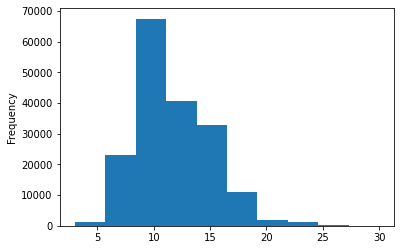

In [17]:
train_df['total lines'].plot.hist()

## Encoding Target

In [18]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse = False)
train_target_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_target_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_target_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_target_label = label_encoder.fit_transform(train_df['target'].to_numpy())
val_target_label = label_encoder.fit_transform(val_df['target'].to_numpy())
test_target_label = label_encoder.fit_transform(test_df['target'].to_numpy())

In [20]:
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

## Model 0 : Baseline MultiNomimalNB

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("classifier",MultinomialNB())
  ]
)
model_0.fit(train_sentences,train_target_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', MultinomialNB())])

In [22]:
model_0.score(val_sentences,val_target_label)

0.7218323844829869

In [23]:
baseline_preds = model_0.predict(val_sentences)

In [24]:
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [25]:
from sklearn.metrics import accuracy_score
accuracy_score(baseline_preds,val_target_label)

0.7218323844829869

In [26]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-24 16:54:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-24 16:54:37 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [27]:
from helper_functions import calculate_results

In [28]:
baseline_results = calculate_results(val_target_label,baseline_preds)

In [29]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing data for deep sequence models

In [30]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as layers

In [31]:
sentences_lengths = [len(sentence.split()) for sentence in train_sentences]

In [32]:
sentences_lengths[:10]

[49, 27, 15, 14, 35, 29, 30, 55, 36, 8]

In [33]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [34]:
print(np.mean(sentences_lengths))

26.338269273494777


(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

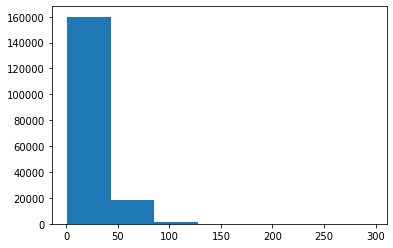

In [35]:
import matplotlib.pyplot as plt
plt.hist(sentences_lengths,bins = 7)

In [36]:
np.percentile(sentences_lengths,95)

55.0

In [37]:
max(sentences_lengths)

296

### Create Text Vectorizer Layer

In [38]:
max_tokens = 68000
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = 55
)

In [39]:
text_vectorizer.adapt(train_sentences)

In [40]:
import random
target_sentence = random.choice(train_sentences)
print("Text:",target_sentence)
print("Length of Text:",len(target_sentence))
print("Vectorizer Text:",text_vectorizer([target_sentence]))

Text: gsk@ treatment was associated with mild to moderate adverse events with headache , dizziness and events related to sleep disturbances being the most common and more pronounced in the early titration period when subjects were first being exposed to gsk@ at the lower @g and @g doses .
Length of Text: 283
Vectorizer Text: tf.Tensor(
[[7071   19   10   81    7  533    6  362  118  124    7 1309 2931    3
   124  328    6  354 3992  571    2  215  317    3   69 2606    5    2
   224 3166  173  183  104    9  152  571 2150    6 7071   15    2  105
   238    3  238  321    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [41]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print("Most common words:",rct_20k_text_vocab[:5])

Most common words: ['', '[UNK]', 'the', 'and', 'of']


In [42]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Custom Token Embeddings

In [43]:
token_embeddings = tf.keras.layers.Embedding(
    input_dim = len(rct_20k_text_vocab),output_dim = 256,
    mask_zero = True #Mask variable lengths
    )

In [44]:
token_embeddings

In [45]:
print("Text :",target_sentence)
print("Vectorized Text:",text_vectorizer([target_sentence]))
print("Embedded Text:",token_embeddings(text_vectorizer([target_sentence])))

Text : gsk@ treatment was associated with mild to moderate adverse events with headache , dizziness and events related to sleep disturbances being the most common and more pronounced in the early titration period when subjects were first being exposed to gsk@ at the lower @g and @g doses .
Vectorized Text: tf.Tensor(
[[7071   19   10   81    7  533    6  362  118  124    7 1309 2931    3
   124  328    6  354 3992  571    2  215  317    3   69 2606    5    2
   224 3166  173  183  104    9  152  571 2150    6 7071   15    2  105
   238    3  238  321    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)
Embedded Text: tf.Tensor(
[[[-0.00507054  0.03320422 -0.04776518 ...  0.01701161  0.01783127
   -0.01430295]
  [-0.01164468 -0.0012536   0.01260902 ...  0.00927434  0.01097958
   -0.02744861]
  [-0.04889598  0.01094159 -0.02033213 ...  0.02820084 -0.01398005
   -0.01749327]
  ...
  [ 0.03165538  0.03687891  0.01205379 ... -0.01491858  0.01095871
   -0.02676143]
  [

### Creating datasets (Fast Loads)

In [46]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_target_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_target_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_target_one_hot))

In [47]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
train_data = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1 : Conv1D with token Embeddings

In [49]:
from tensorflow.keras import layers

In [50]:
inputs = layers.Input(shape = (1,),dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embed = token_embeddings(text_vectors)
x = layers.Conv1D(64,kernel_size = 5,padding = "same",activation = "relu")(token_embed)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5,activation  = "softmax",name = "output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs)
model_1.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [51]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 256)           16599296  
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            81984     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [52]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [53]:
history_1 = model_1.fit(train_data,
      steps_per_epoch = int(0.1*len(train_data)),
      epochs = 3,
      validation_data = val_data,
      validation_steps = int(0.1*len(val_data))
    )

Epoch 1/3
562/562 [==============================] - 36s 50ms/step - loss: 0.8660 - accuracy: 0.6579 - val_loss: 0.6670 - val_accuracy: 0.7470
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6440 - accuracy: 0.7632 - val_loss: 0.6223 - val_accuracy: 0.7776
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6055 - accuracy: 0.7805 - val_loss: 0.5864 - val_accuracy: 0.7886


In [54]:
model_1.evaluate(val_data)

945/945 [==============================] - 3s 3ms/step - loss: 0.5869 - accuracy: 0.7901


[0.5868728756904602, 0.7901496291160583]

In [55]:
model_1_preds_probs = model_1.predict(val_data)

945/945 [==============================] - 2s 2ms/step


In [56]:
model_1_preds_probs.shape

(30212, 5)

In [57]:
model_1_probs = tf.argmax(model_1_preds_probs,axis = 1)

In [58]:
model_1_results = calculate_results(model_1_probs,val_target_label)

In [59]:
model_1_results

{'accuracy': 79.01496094267179,
 'precision': 0.7957151263128691,
 'recall': 0.7901496094267179,
 'f1': 0.7923027170520462}

## Model 2: Feature Extraction with pretrained token embeddings

In [60]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable = False)

In [61]:
random_train_sentence = random.choice(train_sentences)

In [62]:
from tensorflow.keras import layers

inputs = layers.Input(shape = [],dtype = tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128,activation = "relu")(x)
outputs = layers.Dense(5,activation = "softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)
model_2.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [63]:
history_2 = model_2.fit(train_data,steps_per_epoch = int(0.1*len(train_data)),
      epochs = 3,
      validation_data = val_data,
      validation_steps = int(0.1*len(val_data))
    )

Epoch 1/3
562/562 [==============================] - 21s 24ms/step - loss: 0.9178 - accuracy: 0.6462 - val_loss: 0.7955 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 16s 28ms/step - loss: 0.7686 - accuracy: 0.7018 - val_loss: 0.7530 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 16s 28ms/step - loss: 0.7520 - accuracy: 0.7134 - val_loss: 0.7386 - val_accuracy: 0.7134


In [64]:
model_2_preds_probs = model_2.predict(val_data)

945/945 [==============================] - 19s 20ms/step


In [65]:
model_2_probs = tf.argmax(model_2_preds_probs,axis = 1)

In [66]:
model_2_results = calculate_results(model_2_probs,val_target_label)

In [67]:
model_2_results

{'accuracy': 71.36899245332981,
 'precision': 0.7248160077214344,
 'recall': 0.713689924533298,
 'f1': 0.7166899937018297}

## Model 3: Conv1D with Character Embeddings

### Character-Level Tokenizer

In [68]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [69]:
def split_chars(text):
  return " ".join(list(text))

In [70]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [71]:
char_lens = [len(sentence) for sentence in train_sentences]
print(np.mean(char_lens))

149.3662574983337


In [72]:
output_seq_char_len = int(np.percentile(char_lens,95))

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

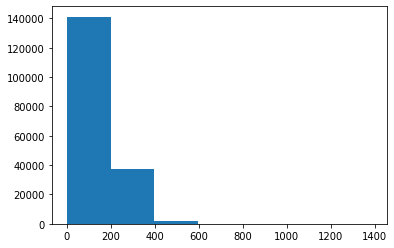

In [73]:
plt.hist(char_lens,bins = 7)

In [74]:
output_seq_char_len

290

In [75]:
import string
tokens = string.ascii_lowercase+string.digits+string.punctuation
tokens

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [76]:
num_char_tokens = len(tokens)+2
char_vectorizer = TextVectorization(max_tokens = num_char_tokens,
  output_sequence_length = output_seq_char_len,name = "char_vectorizer",
  standardize = "lower_and_strip_punctuation"
)

In [77]:
char_vectorizer.adapt(train_chars)

In [78]:
char_vocab = char_vectorizer.get_vocabulary()

In [79]:
print(len(char_vocab))

28


### Character-Level Embedding Layer

In [80]:
character_embeddings = layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25,
    mask_zero = True,
    name = "char_embed"
    )

In [81]:
inputs = layers.Input(shape = (1,),dtype = tf.string)
x = char_vectorizer(inputs)
x = character_embeddings(x)
x = layers.Conv1D(64,10,padding = "same",activation = "relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5,activation = "softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)
model_3.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [82]:
history_3 = model_3.fit(train_data,steps_per_epoch = int(0.1*len(train_data)),
      epochs = 3,
      validation_data = val_data,
      validation_steps = int(0.1*len(val_data))
    ) ## Reason of accuracy being low is that train_data is not optimized for character level model

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.3642 - accuracy: 0.4307 - val_loss: 1.3296 - val_accuracy: 0.4328
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3203 - accuracy: 0.4263 - val_loss: 1.3131 - val_accuracy: 0.4365
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 1.3111 - accuracy: 0.4364 - val_loss: 1.3129 - val_accuracy: 0.3983


### Tuning dataset for character level model

In [83]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [84]:
history_3 = model_3.fit(train_char_dataset,steps_per_epoch = int(0.1*len(train_char_dataset)),
      epochs = 3,
      validation_data = val_char_dataset,
      validation_steps = int(0.1*len(val_char_dataset))
    )

Epoch 1/3
562/562 [==============================] - 5s 8ms/step - loss: 1.2092 - accuracy: 0.5113 - val_loss: 1.0215 - val_accuracy: 0.5848
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9709 - accuracy: 0.6138 - val_loss: 0.9120 - val_accuracy: 0.6406
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.8908 - accuracy: 0.6518 - val_loss: 0.8355 - val_accuracy: 0.6772


In [85]:
model_3_prob_preds = model_3.predict(val_char_dataset)

945/945 [==============================] - 4s 4ms/step


In [86]:
model_3_preds = tf.argmax(model_3_prob_preds,axis = 1)

In [87]:
model_3_results = calculate_results(model_3_preds,val_target_label)

In [88]:
model_3_results

{'accuracy': 67.04289686217398,
 'precision': 0.6999306011096452,
 'recall': 0.6704289686217397,
 'f1': 0.6791884606874993}

## Model 4: Combining pretrained token embeddings + characters embedding

### Token Model

In [90]:
token_inputs = layers.Input(shape = [],dtype = tf.string,name = "token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(100,activation = "relu")(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,outputs = token_output)

### Character Model

In [92]:
char_inputs = layers.Input(shape = (1,),dtype = tf.string,name = "char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = character_embeddings(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # BI-LSTM
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

### Concatenate Token and Character Model

In [116]:
token_char_concat = layers.Concatenate(name = "token_char_hybrid")([token_model.output,char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128,activation = "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output = layers.Dense(5,activation = "softmax")(final_dropout)
model_4 = tf.keras.Model(inputs = [token_model.input,char_model.input],outputs = output)

In [117]:
model_4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_input[0][0]']      

In [118]:
model_4.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ['accuracy'])


In [119]:
from keras.utils import plot_model

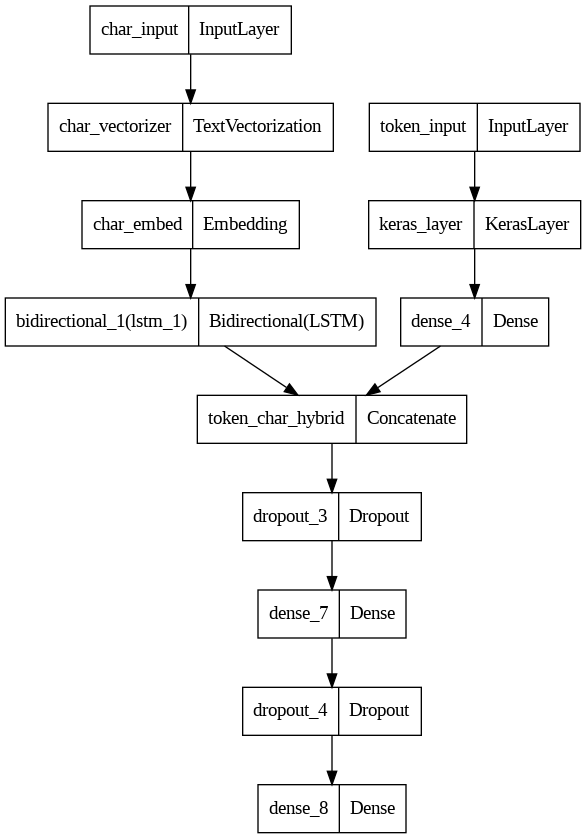

In [120]:
plot_model(model_4)

## Combining Character and Token Data into Dataset

In [112]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_token_char_label = tf.data.Dataset.from_tensor_slices((train_target_one_hot))
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data,train_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [113]:
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_token_char_label = tf.data.Dataset.from_tensor_slices((val_target_one_hot))
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data,val_token_char_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [121]:
history_4 = model_4.fit(train_token_char_dataset,steps_per_epoch = int(0.1*len(train_token_char_dataset)),
      epochs = 3,
      validation_data = val_token_char_dataset,
      validation_steps = int(0.1*len(val_token_char_dataset))
    )

Epoch 1/3
562/562 [==============================] - 41s 55ms/step - loss: 0.9896 - accuracy: 0.6046 - val_loss: 0.7800 - val_accuracy: 0.7028
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.8100 - accuracy: 0.6864 - val_loss: 0.7156 - val_accuracy: 0.7277
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.7863 - accuracy: 0.7010 - val_loss: 0.6987 - val_accuracy: 0.7311


In [123]:
model_4_prob_preds = model_4.predict(val_token_char_dataset)

945/945 [==============================] - 30s 28ms/step


In [124]:
model_4_preds = tf.argmax(model_4_prob_preds,axis = 1)

In [125]:
model_4_results = calculate_results(model_4_preds,val_target_label)

In [127]:
model_4_results

{'accuracy': 72.97431484178473,
 'precision': 0.7392674026016791,
 'recall': 0.7297431484178473,
 'f1': 0.7319473670297745}